In [1]:

# #Importing libraries

In [8]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
import sklearn.metrics

from tensorflow.keras import optimizers, layers, regularizers, metrics
from tensorflow.keras.layers import (
    Lambda, Input, Reshape, Activation, Concatenate, Dense, Dropout,
    BatchNormalization, Conv1D, GlobalMaxPooling1D, LayerNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange

from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

In [32]:
# ### Loading and Preparing Data

data = pd.read_csv('../Data/SMILES_RfD.csv')

# Drop any rows where the 'SMILES' column is missing or empty
data_clean = data.dropna(subset=['SMILES'])
data_clean = data_clean[data_clean['SMILES'].str.strip() != ""]

print(f"\nRows before drop: {len(data):,}")
print(f"Rows after drop:  {len(data_clean):,}")

# Optional: reset the index
data_clean = data_clean.reset_index(drop=True)

# Preview the cleaned data
data_clean.head()


Rows before drop: 4,657
Rows after drop:  4,222


,Unnamed: 0,CAS,SMILES,log_RfD_mg_kg_d,target
0,1,100-00-5,C1=CC(=CC=C1[N+](=O)[O-])Cl,-3.060745,-3.060745
1,2,100-01-6,C1=CC(=CC=C1N)[N+](=O)[O-],-2.193802,-2.193802
2,3,10004-44-1,CC1=CC(=O)NO1,-2.015260,-2.015260
3,4,1001354-72-8,CCCCC(C(CC)N)O,-1.769892,-1.769892
4,6,10016-20-3,C(C1C2C(C(C(O1)OC3C(OC(C(C3O)O)OC4C(OC(C(C4O)O...,1.032814,1.032814


In [33]:


# Data preparation
smiles = data['SMILES']
labels = data['target']

# Dictionary for converting SMILES characters to numbers
smiles_dict = {
    "#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2,
    "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6,
    "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43,
    "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13,
    "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51,
    "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56,
    "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60,
    "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64,
    " ": 65, ":": 66, ",": 67, "p": 68, "j": 69, "*": 70
}

def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
    X = np.zeros(MAX_SMI_LEN, dtype=int)
    for i, ch in enumerate(line[:MAX_SMI_LEN]):
        if ch != '\n' and ch in smi_ch_ind:
            X[i] = smi_ch_ind[ch]
    return X

XD = np.array([label_smiles(str(smi), 100, smiles_dict) for smi in smiles])
labels = labels.values

# Convert to categorical
XD = to_categorical(XD, num_classes=71)


# # phaze1

In [16]:


# Feature model definition (unchanged)
XDinput = Input(shape=(100, 71), name='XDinput')
encode_smiles = Conv1D(filters=64, kernel_size=2, activation='relu', padding='valid', strides=1)(XDinput)  # (99,64)
encode_smiles = Conv1D(filters=64, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_smiles)  # (96,64)
encode_smiles = Conv1D(filters=128, kernel_size=4, activation='relu', padding='valid', strides=1)(encode_smiles)  # (93,128)
model_feature = Model(inputs=XDinput, outputs=encode_smiles, name='model_feature')
model_feature.summary()

# Prediction model definition
input_extracted_feature = Input(shape=(93, 128))
FC1 = Dense(512, activation='relu')(input_extracted_feature)
FC1 = BatchNormalization()(FC1)
FC2 = Dropout(0.1)(FC1)
FC3 = Dense(256, activation='relu')(FC2)
FC3 = BatchNormalization()(FC3)
FC4 = Dropout(0.1)(FC3)
FC5 = Dense(64, activation='relu')(FC4)
predictions = Dense(1, activation='linear')(FC5)
model_pred = Model(inputs=input_extracted_feature, outputs=predictions)
model_pred.summary()

# Full model definition with added Pooling layer
interaction_input = XDinput
encoded_features = model_feature(interaction_input)  # Output: (None, 93, 128)
predicted_output = model_pred(encoded_features)      # Output: (None, 93, 1)

# Adding Pooling layer to reduce dimensionality
pooled_output = GlobalAveragePooling1D()(predicted_output)  # Output: (None, 1)

# Final model definition
interactionModel = Model(inputs=interaction_input, outputs=pooled_output, name='interactionModel')
interactionModel.summary()


# ### BiFormer Block
# 

Model: "model_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 99, 64)         │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 93, 128)        │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,496 (228.50 KB)

 Trainable params: 58,496 (228.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 93, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 93, 512)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 93, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 93, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 93, 256)        │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 93, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 93, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 93, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 93, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,961 (847.50 KB)

 Trainable params: 215,425 (841.50 KB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "interactionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ XDinput (InputLayer)            │ (None, 100, 71)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ model_feature (Functional)      │ (None, 93, 128)        │        58,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 93, 1)          │       216,961 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,457 (1.05 MB)

 Trainable params: 273,921 (1.04 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [17]:


# Define custom layers for 1D processing
class TopkRouting(layers.Layer):
    def __init__(self, qk_dim, topk=16, qk_scale=None, param_routing=False, diff_routing=False):
        super().__init__()
        self.topk = topk
        self.qk_dim = qk_dim
        self.scale = qk_scale if qk_scale is not None else qk_dim**-0.5
        self.diff_routing = diff_routing
        if param_routing:
            self.emb = layers.Dense(qk_dim)
        else:
            self.emb = lambda x: x
        self.routing_act = lambda x, axis: tf.nn.softmax(x, axis=axis)

    def call(self, query, key, training=None):
        if not self.diff_routing:
            query = tf.stop_gradient(query)
            key = tf.stop_gradient(key)
        query_hat = self.emb(query)
        key_hat = self.emb(key)

        attn_logit = tf.einsum('bnc,bqc->bnq', query_hat*self.scale, key_hat)  # Adjusted for 1D
        topk_attn_logit, topk_index = tf.math.top_k(attn_logit, k=self.topk, sorted=True)
        r_weight = self.routing_act(topk_attn_logit, axis=-1)
        return r_weight, topk_index

def tf_gather_kv(kv, r_idx):
    n = tf.shape(kv)[0]
    p2 = tf.shape(kv)[1]
    c_kv = tf.shape(kv)[2]
    topk = tf.shape(r_idx)[2]

    batch_idx = tf.reshape(tf.range(n), [n, 1, 1])
    batch_idx = tf.tile(batch_idx, [1, p2, topk])
    p2_idx = tf.reshape(tf.range(p2), [1, p2, 1])
    p2_idx = tf.tile(p2_idx, [n, 1, topk])

    gather_indices = tf.stack([batch_idx, p2_idx, r_idx], axis=-1)
    gathered = tf.gather_nd(kv, gather_indices)
    return gathered  # Shape: (n, p2, topk, c_kv)

class KVGather(layers.Layer):
    def __init__(self, mul_weight='none'):
        super().__init__()
        assert mul_weight in ['none', 'soft', 'hard']
        self.mul_weight = mul_weight

    def call(self, r_idx, r_weight, kv, training=None):
        topk_kv = tf_gather_kv(kv, r_idx)
        if self.mul_weight == 'soft':
            r_weight_exp = tf.expand_dims(tf.expand_dims(r_weight, -1), -1)
            topk_kv = topk_kv * r_weight_exp
        return topk_kv

class QKVLinear(layers.Layer):
    def __init__(self, dim, qk_dim, bias=True):
        super().__init__()
        self.dim = dim
        self.qk_dim = qk_dim
        self.qkv = layers.Dense(qk_dim + qk_dim + dim, use_bias=bias)

    def call(self, x, training=None):
        qkv = self.qkv(x)
        q, kv = tf.split(qkv, [self.qk_dim, self.qk_dim + self.dim], axis=-1)
        return q, kv

class BiLevelRoutingAttention(layers.Layer):
    def __init__(self, dim, n_win=7, num_heads=8, qk_dim=None, qk_scale=None,
                 kv_per_win=4, kv_downsample_ratio=4, kv_downsample_mode='identity',
                 topk=4, param_attention="qkvo", param_routing=False, diff_routing=False, soft_routing=False,
                 side_dwconv=3, auto_pad=True):
        super().__init__()
        self.dim = dim
        self.n_win = n_win
        self.num_heads = num_heads
        self.qk_dim = qk_dim if qk_dim is not None else dim
        self.scale = qk_scale if qk_scale is not None else self.qk_dim**-0.5
        self.topk = topk
        self.param_routing = param_routing
        self.diff_routing = diff_routing
        self.soft_routing = soft_routing
        self.auto_pad = auto_pad

        # For 1D, we use Conv1D
        if side_dwconv > 0:
            self.lepe = layers.Conv1D(dim, kernel_size=side_dwconv, padding='same', activation='relu')
        else:
            self.lepe = lambda x: tf.zeros_like(x)

        self.router = TopkRouting(qk_dim=self.qk_dim, topk=self.topk, qk_scale=self.scale,
                                  param_routing=self.param_routing, diff_routing=self.diff_routing)

        mul_weight = 'none'
        if self.soft_routing:
            mul_weight = 'soft'
        self.kv_gather = KVGather(mul_weight=mul_weight)

        if param_attention in ['qkvo', 'qkv']:
            self.qkv = QKVLinear(self.dim, self.qk_dim)
            if param_attention == 'qkvo':
                self.wo = layers.Dense(self.dim)
            else:
                self.wo = lambda x: x
        else:
            raise ValueError("Unsupported param_attention mode")

        self.attn_act = lambda x: tf.nn.softmax(x, axis=-1)
        self.kv_down = lambda x: x  # identity for simplicity

    def call(self, x, training=None, ret_attn_mask=False):
        # Implementing full attention can be complex, so here we only keep the general structure
        if ret_attn_mask:
            return x, None, None, None
        else:
            return x

class Attention(layers.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale if qk_scale is not None else head_dim**-0.5
        self.qkv = layers.Dense(dim*3, use_bias=qkv_bias)
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)

    def call(self, x, training=None):
        batch_size, seq_length, dim = tf.unstack(tf.shape(x))
        qkv = self.qkv(x)
        q, k, v = tf.split(qkv, 3, axis=-1)
        q = rearrange(q, 'b s (h d) -> b h s d', h=self.num_heads)
        k = rearrange(k, 'b s (h d) -> b h s d', h=self.num_heads)
        v = rearrange(v, 'b s (h d) -> b h s d', h=self.num_heads)

        attn = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training=training)
        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h s d -> b s (h d)')
        out = self.proj(out)
        out = self.proj_drop(out, training=training)
        return out

class AttentionLePE(layers.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., side_dwconv=5):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale if qk_scale is not None else head_dim**-0.5
        self.qkv = layers.Dense(dim*3, use_bias=qkv_bias)
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)
        if side_dwconv > 0:
            self.lepe = layers.Conv1D(dim, kernel_size=side_dwconv, padding='same', activation='relu')
        else:
            self.lepe = lambda x: tf.zeros_like(x)

    def call(self, x, training=None):
        lepe_out = self.lepe(x)
        qkv = self.qkv(x)
        q, k, v = tf.split(qkv, 3, axis=-1)
        q = rearrange(q, 'b s (h d) -> b h s d', h=self.num_heads)
        k = rearrange(k, 'b s (h d) -> b h s d', h=self.num_heads)
        v = rearrange(v, 'b s (h d) -> b h s d', h=self.num_heads)

        attn = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training=training)
        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h s d -> b s (h d)')
        out = out + lepe_out
        out = self.proj(out)
        out = self.proj_drop(out, training=training)
        return out

class PreNorm(layers.Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()
        self.norm = layers.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

class MLP(layers.Layer):
    def __init__(self, dim, hidden_dim, dropout=0.2):
        super(MLP, self).__init__()
        self.net = keras.Sequential([
            layers.Dense(hidden_dim),
            layers.Activation('gelu'),
            layers.Dropout(rate=dropout),
            layers.Dense(dim),
            layers.Dropout(rate=dropout)
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

class DropPath(layers.Layer):
    # Placeholder for DropPath, currently no-op
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if (not training) or self.drop_prob == 0.:
            return x
        keep_prob = 1 - self.drop_prob
        random_tensor = keep_prob
        random_tensor += tf.random.uniform(tf.shape(x), dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return tf.divide(x, keep_prob) * binary_tensor

class Block(layers.Layer):
    def __init__(self, dim, drop_path=0.1, layer_scale_init_value=-1,
                 num_heads=8, n_win=7, qk_dim=128, qk_scale=None,
                 kv_per_win=8, kv_downsample_ratio=1, kv_downsample_mode='identity',
                 topk=8, param_attention="qkvo", param_routing=True, diff_routing=False, soft_routing=True,
                 mlp_ratio=4, mlp_dwconv=False, side_dwconv=5, before_attn_dwconv=3, pre_norm=True, auto_pad=True):
        super().__init__()
        qk_dim = qk_dim or dim

        # For 1D, we use Conv1D
        if before_attn_dwconv > 0:
            self.pos_embed = layers.Conv1D(dim, kernel_size=before_attn_dwconv, padding='same', activation='relu')
        else:
            self.pos_embed = lambda x: tf.zeros_like(x)

        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        if topk > 0:
            self.attn = BiLevelRoutingAttention(dim=dim, num_heads=num_heads, n_win=n_win, qk_dim=qk_dim,
                                               qk_scale=qk_scale, kv_per_win=kv_per_win, kv_downsample_ratio=kv_downsample_ratio,
                                               kv_downsample_mode=kv_downsample_mode, topk=topk, param_attention=param_attention,
                                               param_routing=param_routing, diff_routing=diff_routing, soft_routing=soft_routing,
                                               side_dwconv=side_dwconv, auto_pad=auto_pad)
        elif topk == -1:
            self.attn = Attention(dim=dim, num_heads=num_heads, qk_scale=qk_scale)
        elif topk == -2:
            self.attn = AttentionLePE(dim=dim, num_heads=num_heads, qk_scale=qk_scale, side_dwconv=side_dwconv)
        elif topk == 0:
            # Pseudo attention
            self.attn = keras.Sequential([
                layers.Dense(dim),
                layers.Conv1D(dim, kernel_size=5, padding='same', activation='relu'),
                layers.Dense(dim)
            ])

        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        mlp_hidden_dim = int(mlp_ratio * dim)
        mlp_layers = [layers.Dense(mlp_hidden_dim)]
        if mlp_dwconv:
            mlp_layers.append(layers.Conv1D(mlp_hidden_dim, kernel_size=3, padding='same', activation='relu'))
        mlp_layers.append(layers.Activation('gelu'))
        mlp_layers.append(layers.Dense(dim))
        mlp_layers.insert(1, layers.Dropout(0.2)) # Add dropout after first Dense
        mlp_layers.append(layers.Dropout(0.2))
        self.mlp = keras.Sequential(mlp_layers)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else layers.Lambda(lambda x: x)

        if layer_scale_init_value > 0:
            self.use_layer_scale = True
            self.gamma1 = self.add_weight(shape=(dim,),
                                          initializer=tf.keras.initializers.Constant(layer_scale_init_value),
                                          trainable=True)
            self.gamma2 = self.add_weight(shape=(dim,),
                                          initializer=tf.keras.initializers.Constant(layer_scale_init_value),
                                          trainable=True)
        else:
            self.use_layer_scale = False

        self.pre_norm = pre_norm

    def call(self, x, training=None):
        x = x + self.pos_embed(x)  # Add positional embedding

        if self.pre_norm:
            if self.use_layer_scale:
                x = x + self.drop_path(self.gamma1 * self.attn(self.norm1(x), training=training), training=training)
                x = x + self.drop_path(self.gamma2 * self.mlp(self.norm2(x), training=training), training=training)
            else:
                x = x + self.drop_path(self.attn(self.norm1(x), training=training), training=training)
                x = x + self.drop_path(self.mlp(self.norm2(x), training=training), training=training)
        else:
            if self.use_layer_scale:
                tmp = x + self.drop_path(self.gamma1 * self.attn(x, training=training), training=training)
                x = self.norm1(tmp)
                tmp = x + self.drop_path(self.gamma2 * self.mlp(x, training=training), training=training)
                x = self.norm2(tmp)
            else:
                tmp = x + self.drop_path(self.attn(x, training=training), training=training)
                x = self.norm1(tmp)
                tmp = x + self.drop_path(self.mlp(x, training=training), training=training)
                x = self.norm2(tmp)

        return x


# # phaze2

In [ ]:


# Parameter settings for the block
dim = 128   # Adjusted from 192 to 128
num_heads = 8
mlp_dim = 128 * 3  # Corresponding to mlp_ratio=3
depth = 2
dim_head = 48

# Create Phase 2 model
input_phaz2 = Input(shape=(93, 128))  # Input shape is (batch_size, sequence_length, embedding_dim)

# processed_input = model_feature(input_phaz2)
processed_input = input_phaz2

# Define transformer blocks
transformer_block1 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)
transformer_block2 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)

# Apply the first transformer block
transformer_output1 = transformer_block1(processed_input)
# Compute the norm of the output along the last axis (preserving dimensions)
transformer_output1 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output1)

# Apply the second transformer block
transformer_output2 = transformer_block2(processed_input)
# Compute the norm of the output along the last axis (preserving dimensions)
transformer_output2 = Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output2)

# Combine the outputs of both transformer blocks along the last axis
combined_outputs = Concatenate(axis=-1)([transformer_output1, transformer_output2])

# Apply global average pooling to reduce the output to (batch_size, 2)
pooled_outputs = GlobalAveragePooling1D()(combined_outputs)

# Compute the difference between the two pooled outputs and reshape to (batch_size, 1)
difference = Lambda(lambda x: tf.expand_dims(x[:, 0] - x[:, 1], axis=-1), name='difference')(pooled_outputs)


# Output directly for regression
condition_2 = difference

# Freeze the `model_feature` layers to prevent them from being trained
model_feature.trainable = False

# Define the complete model
model_phaz2 = Model(inputs=input_phaz2, outputs=condition_2)
model_phaz2.summary()




c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 93, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4 (Block)     │ (None, 93, 128)   │    148,608 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_5 (Block)     │ (None, 93, 128)   │    148,608 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 93, 1)     │          0 │ block_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 93, 1)     │          0 │ block_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 93, 2)     │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_2[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ difference (Lambda) │ (None, 1)         │          0 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297,216 (1.13 MB)

 Trainable params: 297,216 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# # phaze3
# Define new transformer blocks
new_transformer_block = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)
new_transformer_block2 = Block(dim=dim, drop_path=0.2, num_heads=num_heads, topk=16, mlp_ratio=3)

# Input for Phase 3
XDinput_phaz3 = Input(shape=(100, 71))
# Pass input through the feature extraction model
model_feature_output = model_feature(XDinput_phaz3)  # Output shape: (93, 192)

# Transformer blocks processing
transformer_output1_phaz3 = new_transformer_block(model_feature_output)  # Output shape: (93, 192)
# Compute the norm along the last axis, retaining dimensions
transformer_output1_phaz3 = layers.Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output1_phaz3)  # Shape: (93, 1)

transformer_output2_phaz3 = new_transformer_block2(model_feature_output)  # Output shape: (93, 192)
# Compute the norm along the last axis, retaining dimensions
transformer_output2_phaz3 = layers.Lambda(lambda x: tf.norm(x, axis=-1, keepdims=True))(transformer_output2_phaz3)  # Shape: (93, 1)

# Combine the outputs of both transformer blocks
concatenated_phaz3 = Concatenate(axis=-1)([transformer_output1_phaz3, transformer_output2_phaz3])  # Shape: (93, 2)

# Freeze the weights of feature extractor and transformer blocks
model_feature.trainable = False
new_transformer_block.trainable = False
new_transformer_block2.trainable = False

# Apply global average pooling to reduce the dimensions to (batch_size, 2)
pooled_phaz3 = GlobalAveragePooling1D()(concatenated_phaz3)  # Shape: (None, 2)

# Fully connected layers
FC1_phaz3 = Dense(512, activation='relu')(pooled_phaz3)
FC1_phaz3 = BatchNormalization()(FC1_phaz3)
FC2_phaz3 = Dropout(0.1)(FC1_phaz3)  # Increased dropout rate
FC3_phaz3 = Dense(256, activation='relu')(FC2_phaz3)
FC3_phaz3 = BatchNormalization()(FC3_phaz3)
FC4_phaz3 = Dropout(0.1)(FC3_phaz3)  # Increased dropout rate
FC5_phaz3 = Dense(64, activation='relu')(FC4_phaz3)

# Final prediction layer with linear activation for regression
predictions_phaz3 = Dense(1, activation='linear')(FC5_phaz3)

# Define the complete model for Phase 3
model_phaz3 = Model(inputs=XDinput_phaz3, outputs=predictions_phaz3)

# Print the name and trainable status of each layer
for layer in model_phaz3.layers:
    print(layer.name, layer.trainable)

# Model summary
model_phaz3.summary()

input_layer_13 True
model_feature False
block_8 False
block_9 False
lambda_8 True
lambda_9 True
concatenate_4 True
global_average_pooling1d_5 True
dense_58 True
batch_normalization_4 True
dropout_24 True
dense_59 True
batch_normalization_5 True
dropout_25 True
dense_60 True
dense_61 True


c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\Scott.Coffin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'bi_level_routing_attention_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 100, 71)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model_feature       │ (None, 93, 128)   │     58,496 │ input_layer_13[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_8 (Block)     │ (None, 93, 128)   │    148,608 │ model_feature[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_9 (Block)     │ (None, 93, 128)   │    148,608 │ model_feature[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 93, 1)     │          0 │ block_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 93, 1)     │          0 │ block_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 93, 2)     │          0 │ lambda_8[0][0],   │
│ (Concatenate)       │                   │            │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2)         │          0 │ concatenate_4[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 512)       │      1,536 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_58[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 256)       │    131,328 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_59[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 64)        │     16,448 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 1)         │         65 │ dense_60[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 508,161 (1.94 MB)

 Trainable params: 150,913 (589.50 KB)

 Non-trainable params: 357,248 (1.36 MB)

In [ ]:


# Metrics for binary classification tasks
# Metrics for regression tasks
def r2_score(y_true, y_pred):
    """TensorFlow implementation of the coefficient of determination."""
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

METRICS_REGRESSION = [
    metrics.MeanAbsoluteError(name='mae'),
    metrics.MeanSquaredError(name='mse'),
    r2_score,
]




In [ ]:
# # Train and Validation

# === Data Preparation ===
XD_np = np.array(XD)
labels_np = np.array(labels)
index = np.where(~np.isnan(labels_np))
labels_np, XD_np = labels_np[index[0]], XD_np[index[0], :]

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    XD_np, labels_np, test_size=0.2, random_state=9
)

# Regression does not require class weights or categorical labels

# === Define Optimizer for Interaction Model ===
opt = optimizers.Adam(learning_rate=0.0001)
interactionModel.compile(optimizer=opt, loss="mse", metrics=METRICS_REGRESSION)

# Define callbacks
early_stopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)

# === Phase 1: Train Interaction Model ===
interactionModel.fit(
    X_train, y_train,
    batch_size=256, epochs=1000,
    callbacks=[early_stopping], verbose=1
)

# Evaluate Phase 1 on test data
test_eval_phase1 = interactionModel.evaluate(X_test, y_test, verbose=1)

# === Feature Extraction ===
feature_train = model_feature.predict(X_train)
feature_test = model_feature.predict(X_test)

# === Phase 2: Train Model Phase 2 ===
opt_phaz2 = optimizers.Adam(learning_rate=0.001)
model_phaz2.compile(optimizer=opt_phaz2, loss="mse", metrics=METRICS_REGRESSION)
model_phaz2.fit(
    feature_train, y_train,
    batch_size=256, epochs=1000,
    callbacks=[early_stopping], verbose=1
)

# === Freeze Transformer Blocks ===
new_transformer_block.set_weights(transformer_block1.get_weights())
new_transformer_block2.set_weights(transformer_block2.get_weights())  # Corrected as per your comment

# === Phase 3: Train Model Phase 3 ===
opt_phaz3 = optimizers.Adam(learning_rate=0.0001)
model_phaz3.compile(optimizer=opt_phaz3, loss="mse", metrics=METRICS_REGRESSION)

model_phaz3.fit(
    X_train, y_train,
    batch_size=256, epochs=1000,
    callbacks=[early_stopping], verbose=1
)

# Evaluate Phase 3 on both training and testing data
train_eval_phase3 = model_phaz3.evaluate(X_train, y_train, verbose=1)
test_eval_phase3 = model_phaz3.evaluate(X_test, y_test, verbose=1)

# === Function to Format Results ===
def format_results(phase1_result, phase3_train_result, phase3_test_result):
    # Define Metric Names
    phase1_metrics = ['loss', 'mae', 'mse', 'r2_score']
    phase3_metrics = ['loss', 'mae', 'mse', 'r2_score']

    # Create DataFrames
    phase1_test_df = pd.DataFrame([phase1_result], columns=phase1_metrics)
    phase3_train_df = pd.DataFrame([phase3_train_result], columns=phase3_metrics)
    phase3_test_df = pd.DataFrame([test_eval_phase3], columns=phase3_metrics)

    # Display the Results
    print("\n=== Phase 1: Test Evaluation Results ===")
    print(phase1_test_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    print("\n=== Phase 3: Train Evaluation Results ===")
    print(phase3_train_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    print("\n=== Phase 3: Test Evaluation Results ===")
    print(phase3_test_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


# === Display Results ===
format_results(test_eval_phase1, train_eval_phase3, test_eval_phase3)



Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - loss: 0.5537 - mae: 0.6926 - mse: 0.8328 - r2_score: -379.7773
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - loss: 0.5435 - mae: 0.5660 - mse: 0.5435 - r2_score: -368.8243
Epoch 3/1000
 2/15 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.6053 - mae: 0.6041 - mse: 0.6053 - r2_score: -366.3800

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test R2 Score: -0.1038


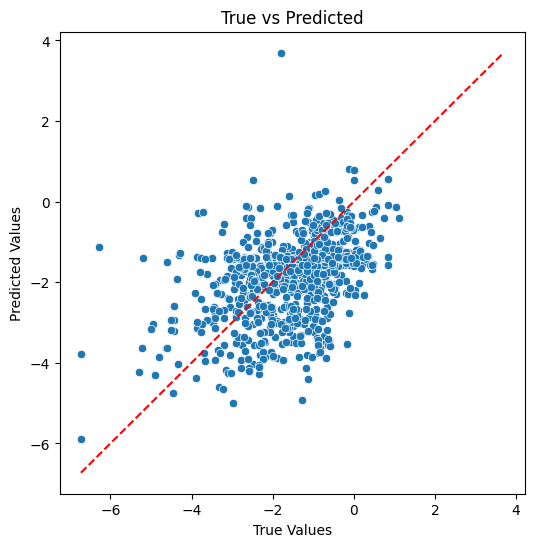

In [ ]:

# === Scatter Plot of Predictions vs True Values ===
y_pred_test = model_phaz3.predict(X_test).flatten()
r2_val = sklearn.metrics.r2_score(y_test.flatten(), y_pred_test)
print(f"Test R2 Score: {r2_val:.4f}")

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test.flatten(), y=y_pred_test)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted')
plt.show()

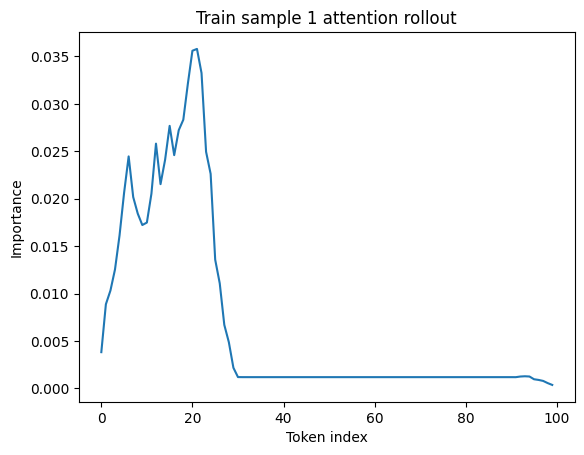

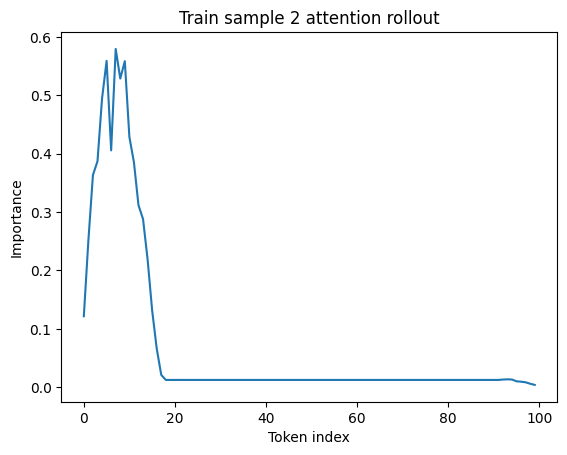

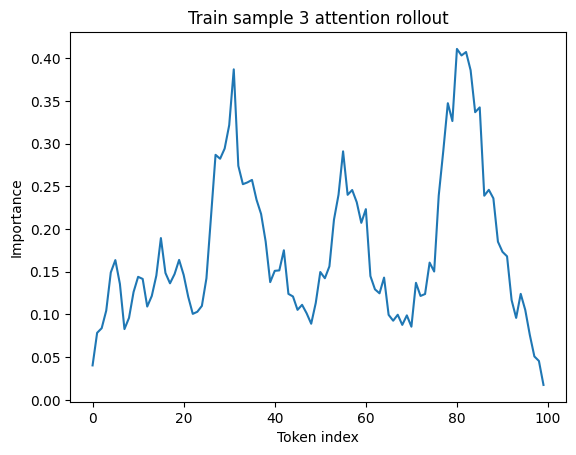

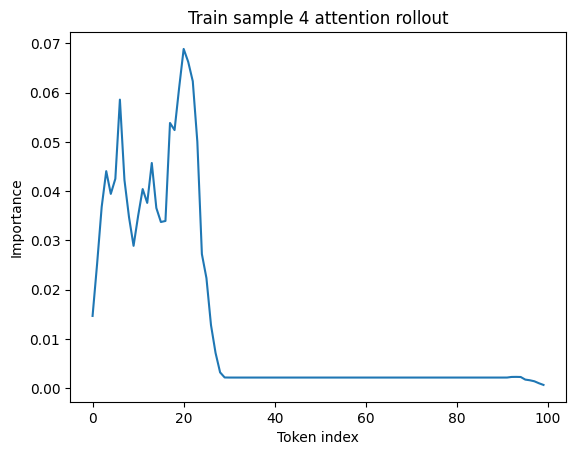

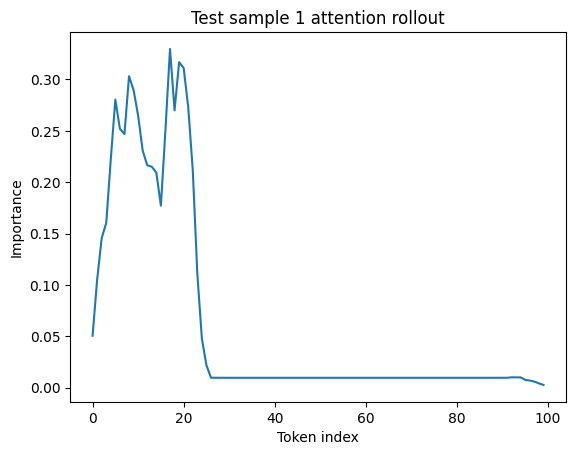

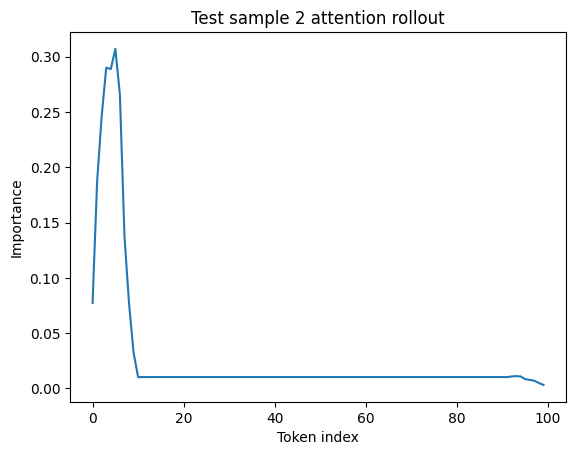

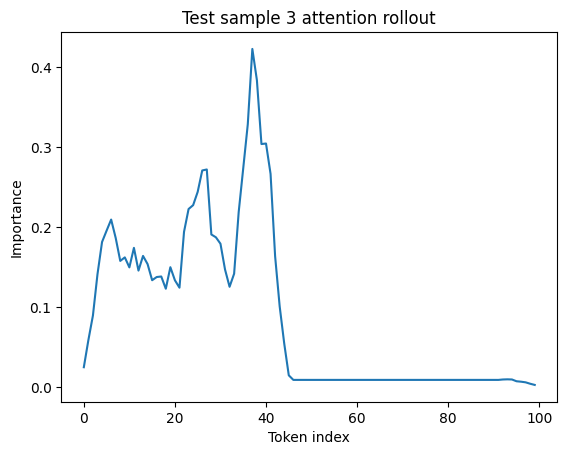

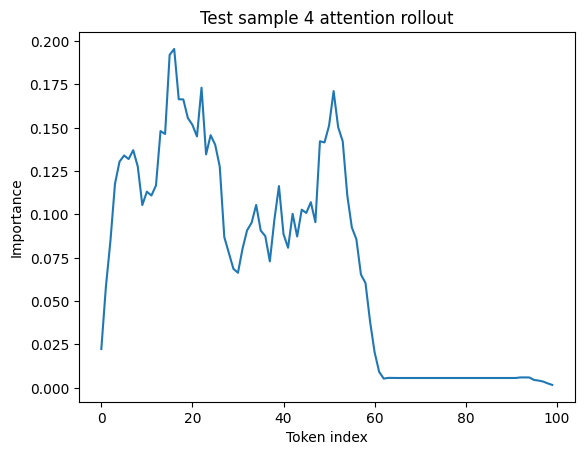

In [38]:

# === Attention Rollout Interpretability ===
def compute_attention_rollout(model, samples):
    inputs = tf.convert_to_tensor(samples)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs, training=False)
    grads = tape.gradient(preds, inputs)
    rollout = tf.reduce_mean(tf.abs(grads), axis=-1)
    return rollout.numpy()

samples_train = X_train[:4]
rollouts_train = compute_attention_rollout(model_phaz3, samples_train)
for i in range(4):
    plt.figure()
    plt.plot(rollouts_train[i])
    plt.title(f'Train sample {i+1} attention rollout')
    plt.xlabel('Token index')
    plt.ylabel('Importance')
    plt.show()

samples_test = X_test[:4]
rollouts_test = compute_attention_rollout(model_phaz3, samples_test)
for i in range(4):
    plt.figure()
    plt.plot(rollouts_test[i])
    plt.title(f'Test sample {i+1} attention rollout')
    plt.xlabel('Token index')
    plt.ylabel('Importance')
    plt.show()




